In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

In [2]:
dev = qml.device("default.qubit", wires=4)

In [3]:
# Define the encoding of th VQC
def state_preparation(a):
    qml.RX(a[0], wires=0)
    qml.RX(a[1], wires=1)
    qml.RX(a[2], wires=2)
    qml.RX(a[3], wires=3)

In [4]:
print(qml.draw(state_preparation, wire_order=[0, 1, 2, 3])([1,1,1,1]))

0: ──RX(1.00)─┤  
1: ──RX(1.00)─┤  
2: ──RX(1.00)─┤  
3: ──RX(1.00)─┤  


In [5]:
# define the ansatz
def ansatz(weights):
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.RY(weights[2], wires=2)
    qml.RY(weights[3], wires=3)
    
   

In [6]:
print(qml.draw(ansatz, wire_order=[0, 1, 2, 3])([1,1,1,1]))

0: ─╭●───────╭X──RY(1.00)─┤  
1: ─╰X─╭●────│───RY(1.00)─┤  
2: ────╰X─╭●─│───RY(1.00)─┤  
3: ───────╰X─╰●──RY(1.00)─┤  


In [7]:
@qml.qnode(dev)
def vqc(weights, a):
    state_preparation(a)
    ansatz(weights)
    return qml.expval(qml.PauliZ(0))
    

0: ──RX(1.00)─╭●───────╭X──RY(0.00)─┤  <Z>
1: ──RX(1.00)─╰X─╭●────│───RY(1.00)─┤     
2: ──RX(1.00)────╰X─╭●─│───RY(2.00)─┤     
3: ──RX(1.00)───────╰X─╰●──RY(3.00)─┤     


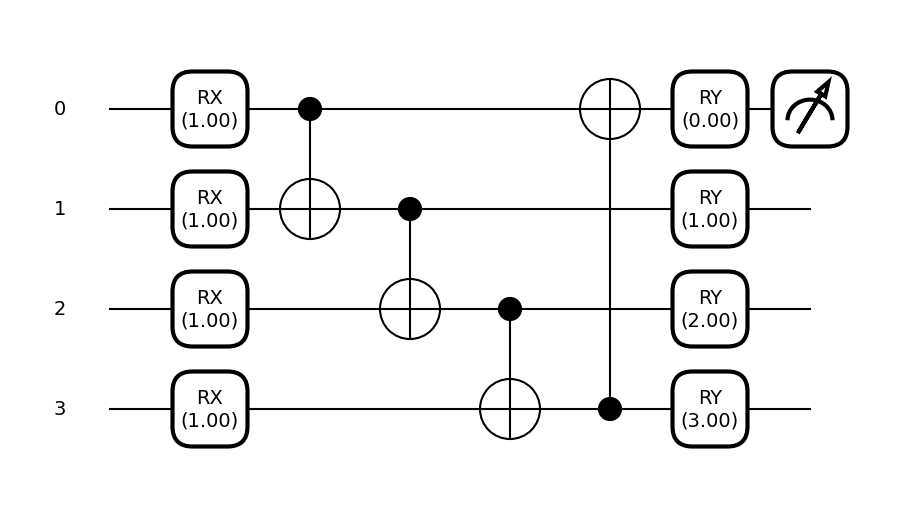

In [8]:
print(qml.draw(vqc,decimals=2)([0,1,2,3],[1,1,1,1]))
qml.draw_mpl(vqc,decimals=2)([0,1,2,3],[1,1,1,1])
plt.show()

In [9]:
def variational_classifier(weights, bias, x):
    return vqc(weights, x) + bias

# Training

In [10]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    #return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])
    return np.array([x[0], x[1],x[2],x[3]])

In [11]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]


In [12]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
print(feats_train.shape)
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
print(feats_val.shape)
Y_val = Y[index[num_train:]]

(75, 4)
(25, 4)


In [56]:
num_qubits = 4
num_layers = 1

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 1, requires_grad=True).squeeze()
weights_init.requires_grad = True
print(weights_init.shape)
print(weights_init)
bias_init = np.array(0.0, requires_grad=True)

(4,)
[ 0.00808984  0.01033786 -0.02170104 -0.01159999]


In [57]:
opt = NesterovMomentumOptimizer(0.001)
batch_size = 20

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(120):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
  
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}\n"
            f"weights: {weights} | bias: {bias}\n"
        )

Iter:     2 | Cost: 1.3250423 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00811389  0.01033786 -0.02170104 -0.01159999] | bias: -0.004866606865973433

Iter:     4 | Cost: 1.3105199 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00816147  0.01033786 -0.02170104 -0.01159999] | bias: -0.014547742983843778

Iter:     6 | Cost: 1.2882764 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00823588  0.01033786 -0.02170104 -0.01159999] | bias: -0.029624893097705884

Iter:     8 | Cost: 1.2623398 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00832437  0.01033786 -0.02170104 -0.01159999] | bias: -0.04760838752777932

Iter:    10 | Cost: 1.2340181 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00842401  0.01033786 -0.02170104 -0.01159999] | bias: -0.06777924013066682

Iter:    12 | Cost: 1.2062030 | Acc train: 0.4800000 | Acc validation: 0.5600000
weights: [ 0.00852452  0.01033786 -0.02170104 -0.01159999] | bias:

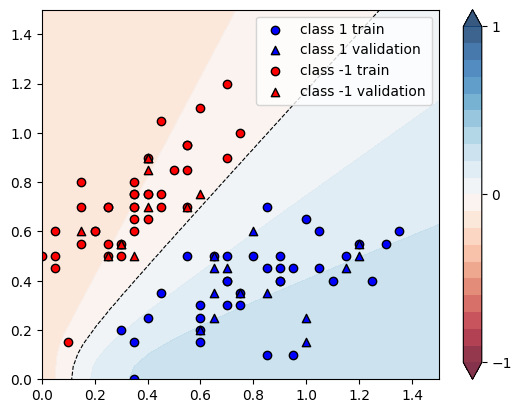

In [58]:
# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

In [59]:
# print final weights and bias
print(f"Final weights: {weights}")
print(f"Final bias: {bias}")

Final weights: [ 0.01064887  0.01033786 -0.02170104 -0.01159999]
Final bias: -0.723465229110216
